In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from keras_tuner import RandomSearch

In [18]:
# 读取数据
df = pd.read_csv('./Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

# 去除列名中的前后空格
df.columns = df.columns.str.strip()

# 检查数据集信息
print("数据集信息:")
print(df.info())

# 处理缺失值
numeric_features = df.select_dtypes(include=[np.number]).columns
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())

# 检查数据中的无穷大和异常值
print("检查无穷大和非常大的值:")
for col in numeric_features:
    if np.isinf(df[col]).any():
        print(f"列 '{col}' 包含无穷大值。")
    if (df[col] > np.finfo(np.float64).max).any():
        print(f"列 '{col}' 包含超出 float64 范围的值。")

# 替换无效值为均值
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())


数据集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             225745 non-null  int64  
 1   Flow Duration                225745 non-null  int64  
 2   Total Fwd Packets            225745 non-null  int64  
 3   Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets  225745 non-null  int64  
 5   Total Length of Bwd Packets  225745 non-null  int64  
 6   Fwd Packet Length Max        225745 non-null  int64  
 7   Fwd Packet Length Min        225745 non-null  int64  
 8   Fwd Packet Length Mean       225745 non-null  float64
 9   Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max        225745 non-null  int64  
 11  Bwd Packet Length Min        225745 non-null  int64  
 12  Bwd Packet Length Mean       225745 non-null  float

In [20]:
# 提取特征和标签
if 'Label' in df.columns:
    X = df.drop('Label', axis=1).values
    y = df['Label'].values
else:
    raise ValueError("数据集中未找到 'Label' 列，请检查列名或数据结构。")

# 将分类标签转换为数值编码
le = LabelEncoder()
y = le.fit_transform(y)

# 数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import tensorflow as tf

# 超参数优化的模型构建函数
def build_model(hp):
    model = Sequential()
    # 使用 Input 层来定义输入的形状
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(
        units=hp.Int('units_layer_1', min_value=32, max_value=512, step=32),
        activation=hp.Choice('activation_layer_1', values=['relu', 'tanh', 'sigmoid'])
    ))
    model.add(Dense(
        units=hp.Int('units_layer_2', min_value=32, max_value=512, step=32),
        activation=hp.Choice('activation_layer_2', values=['relu', 'tanh', 'sigmoid'])
    ))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 使用 Keras Tuner 进行超参数优化
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2
)

Trial 10 Complete [00h 09m 13s]
val_accuracy: 0.9997785091400146

Best val_accuracy So Far: 0.9998615980148315
Total elapsed time: 01h 17m 06s
Epoch 1/50


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4515/4515 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 2/50
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 3/50
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9998 - loss: 9.6324e-04 - val_accuracy: 0.9998 - val_loss: 0.0025
Epoch 4/50
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.9999 - val_loss: 0.0011
Epoch 5/50
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9997 - loss: 9.7036e-04 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 6/50
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9997 - loss: 9.5094e-04 - val_accuracy: 0.9999 - val_loss: 0.0011
Epoch 7/50
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9998 - loss: 6.3855e-04 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 8/50
4515/4515 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9998 - loss: 6.57

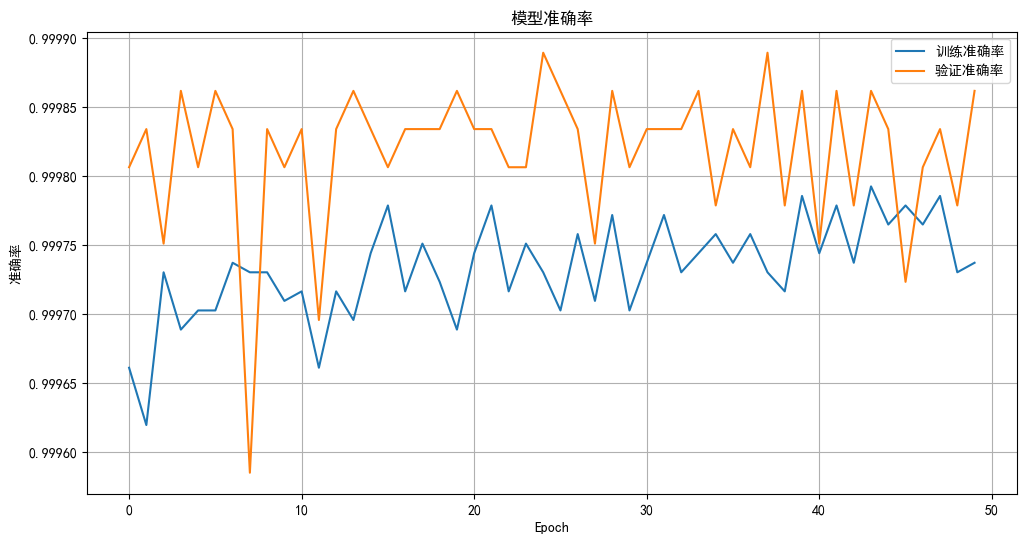

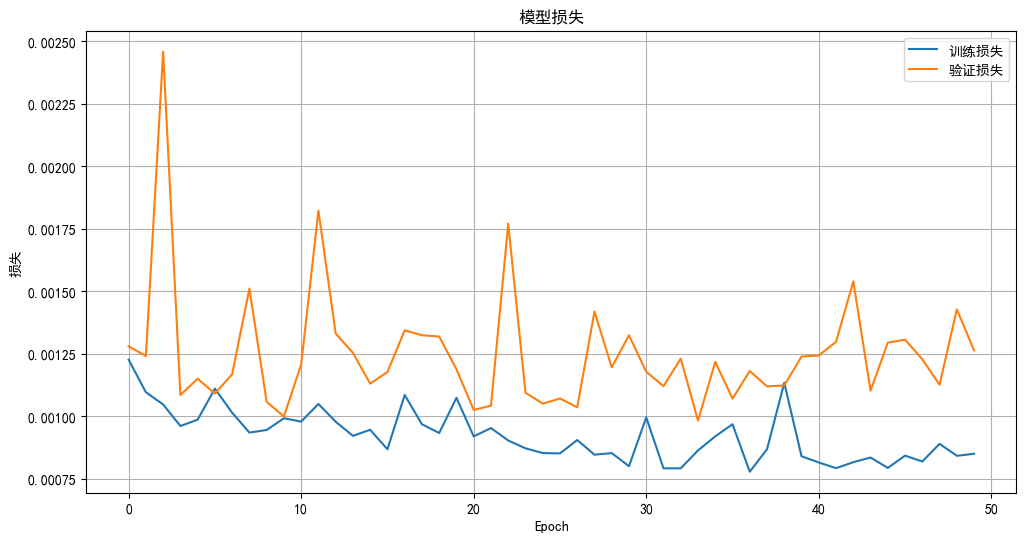

In [24]:
# 搜索最佳模型参数
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# 从搜索结果中获得最佳模型
best_model = tuner.get_best_models(num_models=1)[0]

# 训练最佳模型
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# 模型评估
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# 设置中文字体，防止显示乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 可视化训练过程
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='训练准确率')
plt.plot(history.history['val_accuracy'], label='验证准确率')
plt.title('模型准确率')
plt.xlabel('Epoch')
plt.ylabel('准确率')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('模型损失')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)
plt.show()

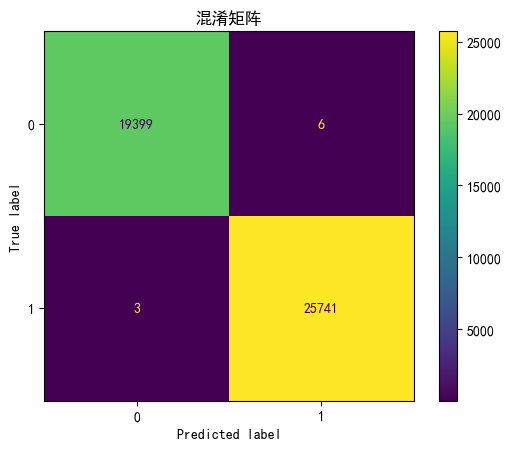

1411/1411 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step


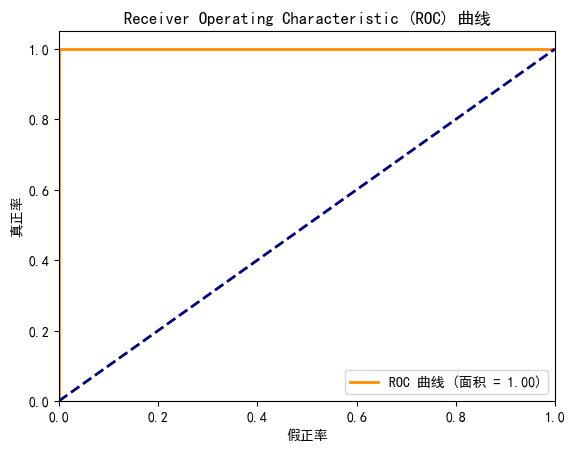

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

# 绘制混淆矩阵
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('混淆矩阵')
plt.show()


from sklearn.metrics import roc_curve, auc

# 计算 ROC 曲线
fpr, tpr, _ = roc_curve(y_test, best_model.predict(X_test))
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC 曲线 (面积 = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正率')
plt.ylabel('真正率')
plt.title('Receiver Operating Characteristic (ROC) 曲线')
plt.legend(loc="lower right")
plt.show()


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step


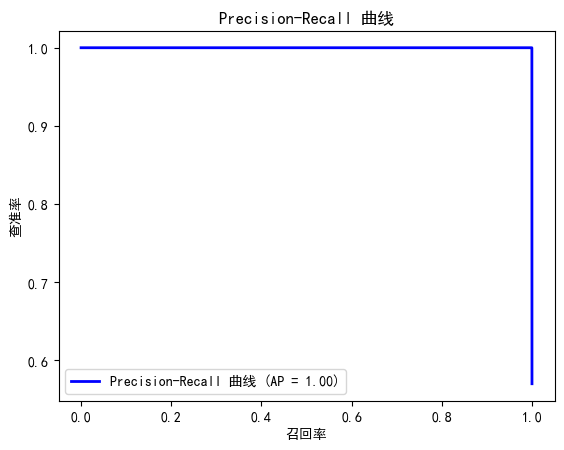

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# 计算 Precision-Recall 曲线
precision, recall, _ = precision_recall_curve(y_test, best_model.predict(X_test))
average_precision = average_precision_score(y_test, y_pred)

# 绘制 Precision-Recall 曲线
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall 曲线 (AP = %0.2f)' % average_precision)
plt.xlabel('召回率')
plt.ylabel('查准率')
plt.title('Precision-Recall 曲线')
plt.legend(loc="lower left")
plt.show()


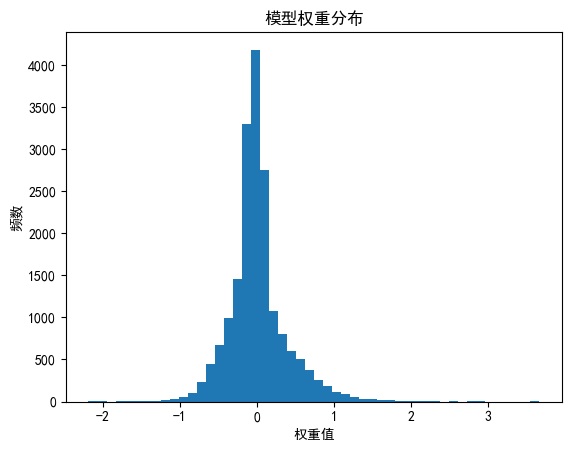

In [36]:
# 获取模型层的权重
weights = best_model.layers[1].get_weights()[0]
plt.hist(weights.flatten(), bins=50)
plt.title('模型权重分布')
plt.xlabel('权重值')
plt.ylabel('频数')
plt.show()
